In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm

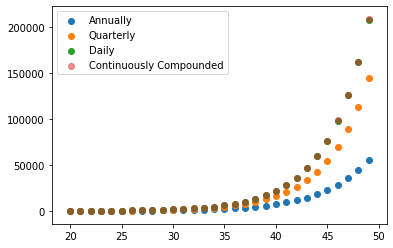

In [2]:
plt.scatter([t for t in range(20,50)], [(1 + .25/(1))**(1*t) for t in range(20,50)], label = "Annually")
plt.scatter([t for t in range(20,50)], [(1 + .25/(4))**(4*t) for t in range(20,50)], label = "Quarterly")
plt.scatter([t for t in range(20,50)], [(1 + .25/(365))**(365*t) for t in range(20,50)], label = "Daily")
plt.scatter([t for t in range(20,50)], [np.exp(.25*t) for t in range(20,50)],alpha = .5, label = "Continuously Compounded")
plt.legend(loc="upper left")

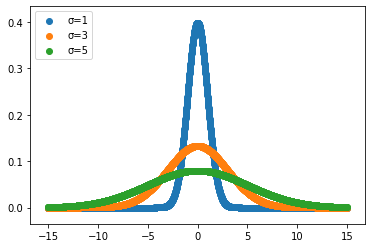

In [4]:
sig = 1
const = 1/(sig*np.sqrt(2*np.pi))
mu = 0
plt.scatter([x/100 for x in range(-1500,1500)], [const*np.exp(-((x/100)-mu)**2/(2*sig**2)) for x in range(-1500,1500)], label = "\u03C3=1")
sig = 3
const = 1/(sig*np.sqrt(2*np.pi))
plt.scatter([x/100 for x in range(-1500,1500)], [const*np.exp(-((x/100)-mu)**2/(2*sig**2)) for x in range(-1500,1500)], label = "\u03C3=3")
sig = 5
const = 1/(sig*np.sqrt(2*np.pi))
plt.scatter([x/100 for x in range(-1500,1500)], [const*np.exp(-((x/100)-mu)**2/(2*sig**2)) for x in range(-1500,1500)], label = "\u03C3=5")
plt.legend(loc="upper left")

In [5]:
def BinomPutPricing(k,s,u,d,r,delta,h):
    Vu = max([k-u,0])
    Vd = max([k-d,0])
    p = (s*np.exp((r-delta)*h) - d) / (u - d)
    V = (Vu*p+Vd*(1-p))*np.exp(-(r-delta)*h)
    return round(p,4),round(V,2)

In [6]:
BinomPutPricing(50,50,60,40,.05,0,1)

(0.6282, 3.54)

In [7]:
def BinomCallPricing(k,s,u,d,r,delta,h):
    Vu = max([u-k,0])
    Vd = max([d-k,0])
    p = (s*np.exp((r-delta)*h) - d) / (u - d)
    V = (Vu*p+Vd*(1-p))*np.exp(-(r-delta)*h)
    return round(p,4),round(V,2)

In [8]:
BinomCallPricing(50,50,60,40,.05,0,1)

(0.6282, 5.98)

In [9]:
def binomial_model(N, S0, u,d, r, K):
    """
    N = number of binomial iterations
    S0 = initial stock price
    u = Price if the stock goes up
    r = CCRFIR
    K = strike price
    """
    u = u/S0
    d = d/S0
    p = (np.exp((r)) - d) / (u - d)
    q = 1 - p

    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N] - K))
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (np.exp(-r) * (p * option[j, i + 1] + q * option[j + 1, i + 1]))
    return round(option[0][0],2)

In [10]:
binomial_model(1,50,60,40,.05,50)

5.98

In [11]:
binomial_model(15,50,1.1*50,.9*50,.05,50)

26.45

In [12]:
tkr = pd.read_csv("SPY.csv")
tkr["CloseDiff"] = [0] + list(np.diff(tkr.Close))

In [13]:
data = tkr
train = data[:round(.75*len(data))]
test = data[round(.75*len(data)):]
x = sm.add_constant([x for x in train["Close"]][:-1])
y = [x for x in train["Close"][1:]]
AR1 = sm.OLS(np.array(y),np.array(x))
results = AR1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     3287.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):          3.62e-120
Time:                        18:43:46   Log-Likelihood:                -621.20
No. Observations:                 188   AIC:                             1246.
Df Residuals:                     186   BIC:                             1253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6322      5.300      1.440      0.152      -2.824      18.088
x1             0.9757      0.017     57.332      0.000       0.942       1.009
==============================================================================
Omnibus:                       54.914   Durbin-Watson:                   2.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.854
Skew:                          -1.129   Prob(JB):                     1.61e-41
Kurtosis:                       7.346   Cond. No.                     3.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
SSE = sum((test["Close"][1:]-results.predict(sm.add_constant([x for x in test["Close"]][:-1])))**2)

In [15]:
SST = (test.Close.std()**2)*test.Close.count()
1 - SSE/SST

0.9209595158945841

In [16]:
yNplusOne = 7.6322+.9757*data.Close[len(data)-1]
se =  np.sqrt(SSE/(len(train) - 3))*(1+.9757**2)
t = 1.6449
CI = (yNplusOne-t*se,yNplusOne+t*se)
print(CI)

(372.59901105390406, 386.65617246009606)


(32.85048495710927, 322.2105166547617)

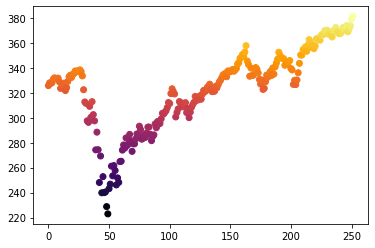

In [17]:
plt.scatter([t for t in range(len(tkr))], tkr.Close,c = tkr.Close,cmap = "inferno")
tkr.Close.std(),tkr.Close.mean()


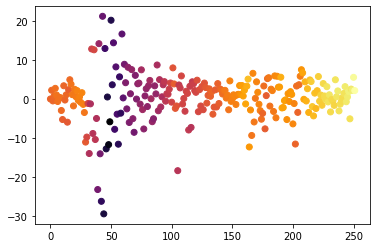

In [18]:
plt.scatter([t for t in range(len(tkr))], tkr.CloseDiff, c = tkr.Close, cmap = "inferno")

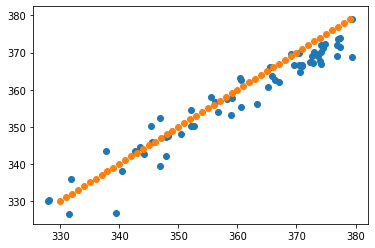

In [19]:
data = tkr
train = data[:round(.75*len(data))]
test = data[round(.75*len(data)):]
train.CloseDiff.mean()
yt = [data.Close[t-1] + train.CloseDiff.mean()*(t - 189) for t in range(190,len(data)-1)]
plt.scatter(yt,[data.Close[t] for t in range(190,len(data)-1)])
plt.scatter([t for t in range(330,380)],[t for t in range(330,380)])

Text(0.0, 1.0, 'SPY Random Walk')

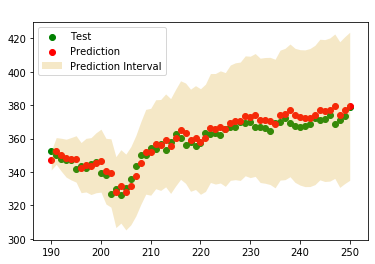

In [20]:
plt.scatter([t for t in range(190,len(data)-1)],[data.Close[t] for t in range(190,len(data)-1)],c = "green", label = "Test")
plt.scatter([t for t in range(190,len(data)-1)],yt,c="red", label = "Prediction")
lower = np.array([yt[i] - 1.6449*test.CloseDiff.std()*np.sqrt(i+1) for i in range(len(yt))])
upper = np.array([yt[i] + 1.6449*test.CloseDiff.std()*np.sqrt(i+1) for i in range(len(yt))])
plt.fill_between([t for t in range(190,len(data)-1)],lower,upper,color='goldenrod', alpha=.25, lw=0, label = "Prediction Interval")
plt.legend(loc="upper left")
plt.title(label = "SPY Random Walk", c = "white", loc = "left")

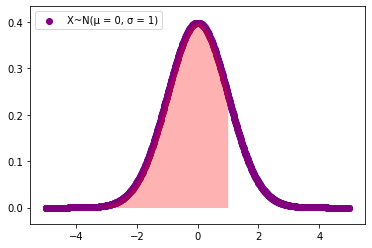

In [21]:
sig = 1
const = 1/(sig*np.sqrt(2*np.pi))
mu = 0
stnorm = [const*np.exp(-((x/100)-mu)**2/(2*sig**2)) for x in range(-500,500)]
plt.scatter([x/100 for x in range(-500,500)], stnorm, label = "X~N(\u03BC = 0, \u03C3 = 1)", c = "purple")
plt.fill_between([x/100 for x in range(-500,100)],[0 for x in range(-500,100)],[stnorm[x] for x in range(600)],color='red', alpha=0.3, lw=0)
plt.legend(loc = "upper left")

In [148]:
np.random.seed(69420)

Text(0.0, 1.0, 'TXFD Market Update')

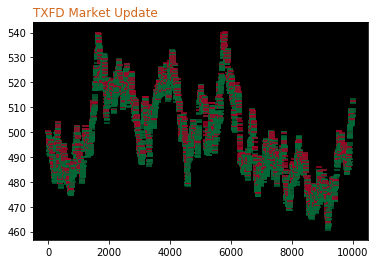

In [157]:
rw = [500]
for i in range(10000):
    rw.append(rw[-1]+st.norm.rvs())
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('xkcd:black')
plt.scatter([t for t in range(10000)],rw[:10000], marker = "_",
            cmap = "RdYlGn",c = [0 if rw[t] - rw[t-1] < -.75 else 1 for t in range(1,10001)])
plt.title(label = "TXFD Market Update", c = "chocolate", loc = "left")